In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/cloud-dataset

/content/drive/MyDrive/cloud-dataset


In [ ]:
!pip install tf-nightly

In [ ]:
!unzip drive/MyDrive/cloud-dataset/train_gt.zip -d train_gt

# TRAIN

In [3]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import keras.backend as K
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
lr = 1e-4
height = 384
width = 384
files_dir = os.path.join("files")
model_file = os.path.join(files_dir, "unet-checkpoint.h5")
log_file = os.path.join(files_dir, "log.csv")

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

def load_data(train_count, val_count):
    train_x = sorted(glob(os.path.join("train_blue", "*")))[:train_count]
    train_y = sorted(glob(os.path.join("train_gt", "*")))[:train_count]

    valid_x = sorted(glob(os.path.join("train_blue", "*")))[train_count:train_count+val_count]
    valid_y = sorted(glob(os.path.join("train_gt", "*")))[train_count:train_count+val_count]

    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])

    return x, y

def tf_dataset(x, y, batch=1):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

input_shape = (height, width, 3)

callbacks= [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False)
]

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

binary_iou = tf.keras.metrics.BinaryIoU(name='IoU')
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()


In [ ]:
epochs = 30
batch_size = 2
train_count = 1000
val_count = 300

In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(train_count, val_count)
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}")

model = build_unet(input_shape)
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc", binary_iou, recall, precision])

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,

)

Train: 500, Valid: 150
Epoch 1/30
500/500 [==============================] - ETA: 0s - loss: 0.4755 - acc: 0.7984 - IoU: 0.6318 - recall: 0.6536 - precision: 0.7220
Epoch 1: val_loss improved from 0.69080 to 0.48347, saving model to files/unet-checkpoint.h5
500/500 [==============================] - 361s 700ms/step - loss: 0.4755 - acc: 0.7984 - IoU: 0.6318 - recall: 0.6536 - precision: 0.7220 - val_loss: 0.4835 - val_acc: 0.7187 - val_IoU: 0.5609 - val_recall: 0.9723 - val_precision: 0.5741 - lr: 1.0000e-04
Epoch 2/30
500/500 [==============================] - ETA: 0s - loss: 0.3946 - acc: 0.8284 - IoU: 0.6804 - recall: 0.7264 - precision: 0.7552
Epoch 2: val_loss improved from 0.48347 to 0.41800, saving model to files/unet-checkpoint.h5
500/500 [==============================] - 539s 1s/step - loss: 0.3946 - acc: 0.8284 - IoU: 0.6804 - recall: 0.7264 - precision: 0.7552 - val_loss: 0.4180 - val_acc: 0.7881 - val_IoU: 0.6483 - val_recall: 0.9274 - val_precision: 0.6535 - lr: 1.0000e-0

In [ ]:
epochs = 30
batch_size = 4      # before: 2
train_count = 1000
val_count = 300

In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(train_count, val_count)
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}")

model = build_unet(input_shape)
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc", binary_iou, precision, recall])

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Train: 250, Valid: 75
Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.5355 - acc: 0.7722 - IoU: 0.6087 - precision: 0.6234 - recall: 0.7682
Epoch 1: val_loss improved from inf to 0.73182, saving model to files/unet-checkpoint.h5
250/250 [==============================] - 311s 1s/step - loss: 0.5355 - acc: 0.7722 - IoU: 0.6087 - precision: 0.6234 - recall: 0.7682 - val_loss: 0.7318 - val_acc: 0.4466 - val_IoU: 0.2590 - val_precision: 0.4043 - val_recall: 0.9999 - lr: 1.0000e-04
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.4633 - acc: 0.8120 - IoU: 0.6612 - precision: 0.7086 - recall: 0.7515
Epoch 2: val_loss improved from 0.73182 to 0.59046, saving model to files/unet-checkpoint.h5
250/250 [==============================] - 151s 604ms/step - loss: 0.4633 - acc: 0.8120 - IoU: 0.6612 - precision: 0.7086 - recall: 0.7515 - val_loss: 0.5905 - val_acc: 0.6388 - val_IoU: 0.4657 - val_precision: 0.5097 - val_recall: 0.9980 - lr: 1.0000e-04
Epo

In [ ]:
epochs = 30
batch_size = 2
train_count = 2000  # before: 1000
val_count = 600     # before: 300

In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(train_count, val_count)
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}")

model = build_unet(input_shape)
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc", binary_iou, precision, recall])

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Train: 1000, Valid: 300
Epoch 1/30
1000/1000 [==============================] - ETA: 0s - loss: 0.4353 - acc: 0.8105 - IoU: 0.6822 - precision: 0.7452 - recall: 0.7734
Epoch 1: val_loss did not improve from 0.23525
1000/1000 [==============================] - 496s 482ms/step - loss: 0.4353 - acc: 0.8105 - IoU: 0.6822 - precision: 0.7452 - recall: 0.7734 - val_loss: 0.4517 - val_acc: 0.7840 - val_IoU: 0.6194 - val_precision: 0.7780 - val_recall: 0.6122 - lr: 1.0000e-04
Epoch 2/30
1000/1000 [==============================] - ETA: 0s - loss: 0.3358 - acc: 0.8555 - IoU: 0.7308 - precision: 0.8047 - recall: 0.7910
Epoch 2: val_loss did not improve from 0.23525
1000/1000 [==============================] - 307s 307ms/step - loss: 0.3358 - acc: 0.8555 - IoU: 0.7308 - precision: 0.8047 - recall: 0.7910 - val_loss: 0.4399 - val_acc: 0.7871 - val_IoU: 0.6323 - val_precision: 0.7387 - val_recall: 0.6894 - lr: 1.0000e-04
Epoch 3/30
1000/1000 [==============================] - ETA: 0s - loss: 0.2781

In [ ]:
epochs = 30
batch_size = 4      # before: 2
train_count = 2000
val_count = 600

In [ ]:
(train_x, train_y), (valid_x, valid_y) = load_data(train_count, val_count)
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

print(f"Train: {len(train_dataset)}, Valid: {len(valid_dataset)}")

model = build_unet(input_shape)
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc", binary_iou, precision, recall])

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

8400
train_blue/blue_patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1.TIF 2000
Train: 500, Valid: 150
Epoch 1/30
500/500 [==============================] - ETA: 0s - loss: 0.4348 - acc: 0.8158 - IoU: 0.6681 - precision: 0.7568 - recall: 0.7202
Epoch 1: val_loss improved from inf to 0.45926, saving model to files/unet-checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 364s 650ms/step - loss: 0.4348 - acc: 0.8158 - IoU: 0.6681 - precision: 0.7568 - recall: 0.7202 - val_loss: 0.4593 - val_acc: 0.7409 - val_IoU: 0.5884 - val_precision: 0.5990 - val_recall: 0.9842 - lr: 1.0000e-04
Epoch 2/30
500/500 [==============================] - ETA: 0s - loss: 0.3679 - acc: 0.8421 - IoU: 0.7096 - precision: 0.7864 - recall: 0.7714
Epoch 2: val_loss improved from 0.45926 to 0.34159, saving model to files/unet-checkpoint.h5
500/500 [==============================] - 324s 647ms/step - loss: 0.3679 - acc: 0.8421 - IoU: 0.7096 - precision: 0.7864 - recall: 0.7714 - val_loss: 0.3416 - val_acc: 0.8173 - val_IoU: 0.6890 - val_precision: 0.6937 - val_recall: 0.9389 - lr: 1.0000e-04
Epoch 3/30
500/500 [==============================] - ETA: 0s - loss: 0.3329 - acc: 0.8568 - IoU: 0.7331 - precision: 0.8044 - recall: 0.7962
Epoch 3: val_loss did not improve from 0.34159
500/500 [==============================] - 323s 646ms/step - los

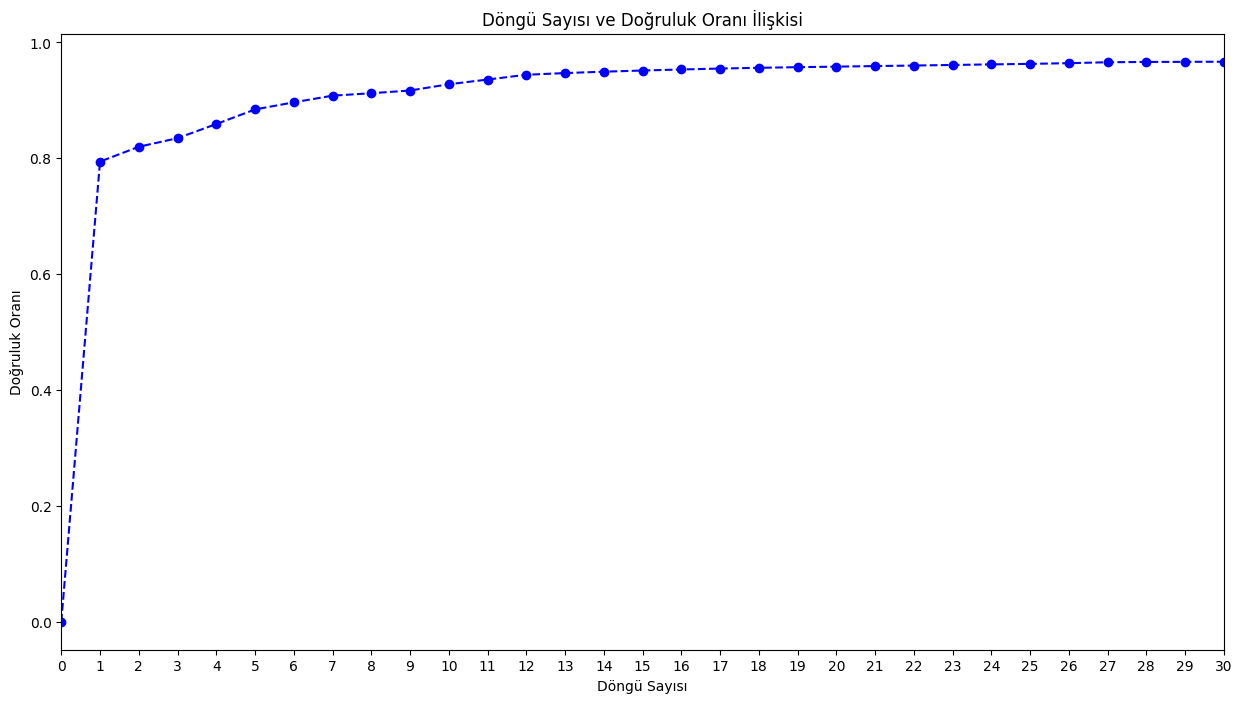

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

accs = [0,0.7943, 0.8199, 0.8347, 0.8591, 0.8843, 0.8966, 0.9081, 0.9123, 0.9170, 0.9278, 0.9359, 0.9442, 0.9471, 0.9495, 0.9515, 0.9533, 0.9549, 0.9562, 0.9573, 0.9582, 0.9592, 0.9601, 0.9611, 0.9621, 0.9630, 0.9642, 0.9658, 0.9663, 0.9665, 0.9667]
epochs = list(range(0,31))

plt.figure(figsize=(15,8))
plt.margins(x=0)
plt.xticks(epochs)
plt.plot(epochs, accs, "--bo")
plt.title('Döngü Sayısı ve Doğruluk Oranı İlişkisi')
plt.xlabel('Döngü Sayısı')
plt.ylabel('Doğruluk Oranı')

plt.show()


# PREDICT

In [5]:
import os
import time
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from google.colab.patches import cv2_imshow

os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

In [6]:
!pwd

/content/drive/MyDrive/cloud-dataset


In [11]:
height = 384
width = 384

model_path = "files/unet-checkpoint.h5"
model = tf.keras.models.load_model(model_path)

save_path = "predict/"

In [12]:
train_blue = sorted(glob(os.path.join("train_blue", "*")))
train_gt = sorted(glob(os.path.join("train_gt", "*")))
# test_index = [6864, 6735, 6632, 6587, 6572, 6517, 6390, 6309, 6293, 6291, 6275, 6273, 6257, 6255, 6233, 6161, 6125, 6089, 5880, 5879]
test_index = [6864]

blue_test = []
gt_test = []

for i in test_index:
    blue_test.append(train_blue[i])
    gt_test.append(train_gt[i])


In [ ]:
gt_test

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
train_blue/blue_patch_456_21_by_16_LC08_L1TP_061017_20160720_20170223_01_T1.TIF


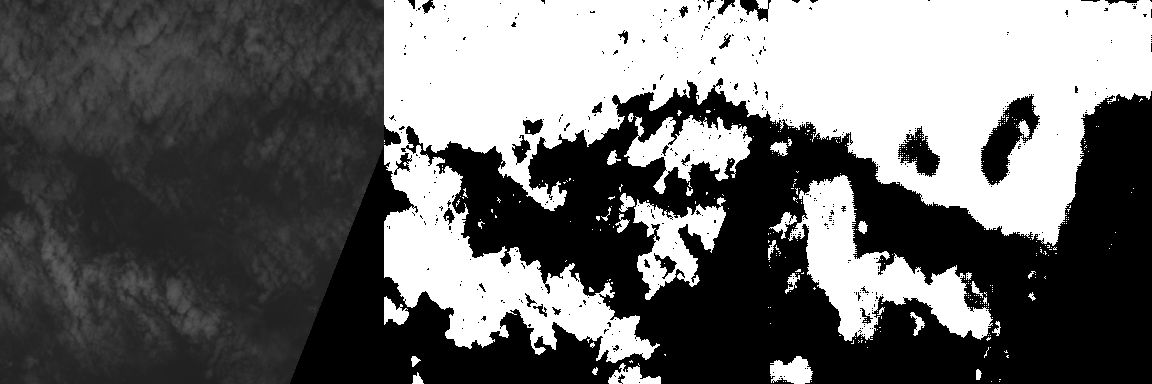

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

Mean Time:  0.22562 - Mean FPS: 4.43222


In [14]:
time_taken = []
i = 0
for im in tqdm(blue_test):
    name = f"{i}.png"
    x = cv2.imread(im, cv2.IMREAD_COLOR)
    x = x/255.0
    x = np.expand_dims(x, axis=0)

    start_time = time.time()
    p = model.predict(x)[0]
    total_time = time.time()-start_time
    time_taken.append(total_time)

    p = p>0.5
    p = p*255.0

    print(blue_test[i])
    cv2.imwrite(os.path.join(save_path, f"p-{name}"), p)
    b = cv2.imread(train_blue[test_index[i]])
    g = cv2.imread(train_gt[test_index[i]])
    cv2.imwrite(os.path.join(save_path, f"g-{name}"), p)
    f = np.concatenate((b,g), axis= 1)
    p = np.dstack([p,p,p])

    final = np.concatenate((f,p), axis= 1)
    cv2_imshow(final)
    i += 1

mean_time = np.mean(time_taken)
mean_fps = 1/mean_time
print(f"Mean Time: {mean_time: 1.5f} - Mean FPS: {mean_fps:2.5f}")